# Pancreatic endorine analysis - RegVelo training and performance benchmark

## Library imports

In [1]:
import tensorflow
import scvelo as scv
import scanpy as sc
import cellrank as cr
from anndata import AnnData
from typing import Iterable, List, Literal, Optional, Sequence, Tuple, Union,Collection
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
from collections import Counter

from scvelo.preprocessing.moments import get_moments
from scvelo.plotting.simulation import compute_dynamics
from scipy.spatial.distance import cdist
from scipy.stats import wilcoxon
from scipy.stats import ranksums

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
from matplotlib.colors import ListedColormap
import mplscience

import torch
import torch.nn.functional as F
import regvelovi
from regvelovi import REGVELOVI
from velovi import preprocess_data, VELOVI
import anndata
from scipy.stats import wilcoxon

import os
import sys
sys.path.append("../..")
from paths import FIG_DIR, DATA_DIR

2024-08-05 00:23:38.772734: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 00:23:38.773033: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 00:23:38.788006: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 00:23:40.000621: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 00:24:13.609014: W tensorflow/compiler/

## General settings 

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map='viridis')

In [3]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'pancreatic_endocrine',exist_ok = True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / 'pancreatic_endocrine',exist_ok = True)

In [4]:
def min_max_scaling(data):
    """
    Apply min-max scaling to a numpy array or pandas Series.

    Parameters:
    data (np.ndarray or pd.Series): The input data to be scaled.

    Returns:
    np.ndarray or pd.Series: Scaled data with values between 0 and 1.
    """
    min_val = np.min(data)
    max_val = np.max(data)
    
    scaled_data = (data - min_val) / (max_val - min_val)
    
    return scaled_data
    
def add_regvelo_outputs_to_adata(adata_raw, vae, filter = False):
    latent_time = vae.get_latent_time(n_samples=30, time_statistic = "mean",batch_size = adata_raw.shape[0])
    velocities = vae.get_velocity(n_samples=30, velo_statistic="mean",batch_size = adata_raw.shape[0])

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_regvelo"] = latent_time
    
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

def add_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
def _in_silico_block_simulation(model,adata, gene,regulation_block = True, target_block = True,effects = 0,cutoff = 1e-3):
    reg_vae_perturb = REGVELOVI.load(model,adata)
    perturb_GRN = reg_vae_perturb.module.v_encoder.fc1.weight.detach().clone()
    
    if regulation_block:
        perturb_GRN[(perturb_GRN[:,[i == gene for i in adata.var.index]].abs()>cutoff).cpu().numpy().reshape(-1),[i == gene for i in adata.var.index]] = effects
    if target_block:
        perturb_GRN[[i == gene for i in adata_target.var.index],(perturb_GRN[[i == gene for i in adata_target.var.index],:].abs()>1e-3).cpu().numpy().reshape(-1)] = effects
    
    reg_vae_perturb.module.v_encoder.fc1.weight.data = perturb_GRN
    adata_target_perturb = add_velovi_outputs_to_adata(adata, reg_vae_perturb)
    
    return adata_target_perturb,reg_vae_perturb

def get_fit_scvelo(adata):
    scvelo_fit_s = pd.DataFrame(
        np.zeros_like(adata.layers["Ms"]),
        index=adata.obs_names,
        columns=adata.var_names,
    )
    scvelo_fit_u = pd.DataFrame(
        np.zeros_like(adata.layers["Ms"]),
        index=adata.obs_names,
        columns=adata.var_names,
    )

    for i, g in tqdm(enumerate(adata.var_names)):
        _, ut, st = compute_dynamics(
            adata,
            basis=adata.var_names[i],
            key="fit",
            extrapolate=False,
            sort=False,
            t=None,
        )
        scvelo_fit_s[g] = st
        scvelo_fit_u[g] = ut
    return scvelo_fit_s, scvelo_fit_u

def compute_mse(ms, mu, fit_s, fit_u):
    mse_s = np.mean((fit_s - ms) ** 2, axis=0)
    mse_u = np.mean((fit_u - mu) ** 2, axis=0)
    #scvelo_mse_s = np.mean((scvelo_fit_s - ms) ** 2, axis=0)
    #scvelo_mse_u = np.mean((scvelo_fit_u - mu) ** 2, axis=0)

    mse_df = pd.DataFrame()

    mse_df["MSE"] = np.concatenate([mse_s, mse_u]).ravel()
    mse_df["Feature"] = ["Spliced"] * len(mse_s) + ["Unspliced"] * len(mse_u)
    return mse_df

def rgv_expression_fit(
        self,
        adata: Optional[AnnData] = None,
        indices: Optional[Sequence[int]] = None,
        gene_list: Optional[Sequence[str]] = None,
        n_samples: int = 1,
        batch_size: Optional[int] = None,
        return_mean: bool = True,
        return_numpy: Optional[bool] = None,
        restrict_to_latent_dim: Optional[int] = None,
    ) -> Union[np.ndarray, pd.DataFrame]:
        r"""Returns the fitted spliced and unspliced abundance (s(t) and u(t)).

        Parameters
        ----------
        adata
            AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
            AnnData object used to initialize the model.
        indices
            Indices of cells in adata to use. If `None`, all cells are used.
        gene_list
            Return frequencies of expression for a subset of genes.
            This can save memory when working with large datasets and few genes are
            of interest.
        n_samples
            Number of posterior samples to use for estimation.
        batch_size
            Minibatch size for data loading into model. Defaults to `scvi.settings.batch_size`.
        return_mean
            Whether to return the mean of the samples.
        return_numpy
            Return a :class:`~numpy.ndarray` instead of a :class:`~pandas.DataFrame`. DataFrame includes
            gene names as columns. If either `n_samples=1` or `return_mean=True`, defaults to `False`.
            Otherwise, it defaults to `True`.

        Returns
        -------
        If `n_samples` > 1 and `return_mean` is False, then the shape is `(samples, cells, genes)`.
        Otherwise, shape is `(cells, genes)`. In this case, return type is :class:`~pandas.DataFrame` unless `return_numpy` is True.
        """
        adata = self._validate_anndata(adata)

        scdl = self._make_data_loader(
            adata=adata, indices=indices, batch_size=batch_size
        )

        if gene_list is None:
            gene_mask = slice(None)
        else:
            all_genes = adata.var_names
            gene_mask = [True if gene in gene_list else False for gene in all_genes]

        if n_samples > 1 and return_mean is False:
            if return_numpy is False:
                warnings.warn(
                    "return_numpy must be True if n_samples > 1 and return_mean is False, returning np.ndarray"
                )
            return_numpy = True
        if indices is None:
            indices = np.arange(adata.n_obs)

        fits_s = []
        fits_u = []
        for tensors in scdl:
            minibatch_samples_s = []
            minibatch_samples_u = []
            for _ in range(n_samples):
                inference_outputs, generative_outputs = self.module.forward(
                    tensors=tensors,
                    compute_loss=False,
                )
                px_rho = generative_outputs["px_rho"]

                ind_t = self.module.t_max * px_rho
                fit_u, fit_s, _ = self.module._get_induction_unspliced_spliced(
                    ind_t
                )

                fit_s = fit_s[..., gene_mask]
                fit_s = fit_s.detach().cpu().numpy()
                fit_u = fit_u[..., gene_mask]
                fit_u = fit_u.detach().cpu().numpy()

                minibatch_samples_s.append(fit_s)
                minibatch_samples_u.append(fit_u)

            # samples by cells by genes
            fits_s.append(np.stack(minibatch_samples_s, axis=0))
            if return_mean:
                # mean over samples axis
                fits_s[-1] = np.mean(fits_s[-1], axis=0)
            # samples by cells by genes
            fits_u.append(np.stack(minibatch_samples_u, axis=0))
            if return_mean:
                # mean over samples axis
                fits_u[-1] = np.mean(fits_u[-1], axis=0)

        if n_samples > 1:
            # The -2 axis correspond to cells.
            fits_s = np.concatenate(fits_s, axis=-2)
            fits_u = np.concatenate(fits_u, axis=-2)
        else:
            fits_s = np.concatenate(fits_s, axis=0)
            fits_u = np.concatenate(fits_u, axis=0)

        if return_numpy is None or return_numpy is False:
            df_s = pd.DataFrame(
                fits_s,
                columns=adata.var_names[gene_mask],
                index=adata.obs_names[indices],
            )
            df_u = pd.DataFrame(
                fits_u,
                columns=adata.var_names[gene_mask],
                index=adata.obs_names[indices],
            )
            return df_s, df_u
        else:
            return fits_s, fits_u

In [5]:
def prior_GRN(adata, gt_net):
    regulators = adata.var.index.tolist()
    targets = adata.var.index.tolist()
    skeleton = pd.DataFrame(np.zeros([len(regulators),len(targets)]),index = regulators,columns = targets)
    skeleton.loc[set(regulators).intersection(gt_net.index),set(targets).intersection(gt_net.columns)] = \
            gt_net.loc[set(regulators).intersection(gt_net.index),set(targets).intersection(gt_net.columns)]
    gt_net = skeleton.copy()

    ## filter low co-expressed GRN
    regulator_index = [i in gt_net.columns for i in adata.var.index.values]
    target_index = [i in gt_net.index for i in adata.var.index.values]
    
    corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
    corr_m = torch.tensor(corr_m)
    corr_m = corr_m[target_index,]
    corr_m = corr_m[:,regulator_index]
    corr_m = corr_m.float()

    corr_m[np.isnan(corr_m)] = 0
    corr_m = pd.DataFrame(corr_m, index = adata.var.index.values[regulator_index], columns = adata.var.index.values[target_index])
    gt_net = gt_net.loc[corr_m.index,corr_m.columns]
    GRN_final = gt_net * corr_m

    GRN_final[abs(GRN_final)<0.01] = 0
    GRN_final[GRN_final!=0] = 1
    for i in GRN_final.columns:
        GRN_final.loc[i,i] = 0
    skeleton.loc[GRN_final.index.tolist(),GRN_final.columns.tolist()] = GRN_final

    W = skeleton.copy()
    reg_bdata = adata[:,skeleton.index].copy()

    W = W.loc[reg_bdata.var.index.values.tolist(),reg_bdata.var.index.values.tolist()]
    W = torch.tensor(np.array(W))
    reg_bdata.uns["regulators"] = reg_bdata.var.index.values
    reg_bdata.uns["targets"] = reg_bdata.var.index.values
    intersection = list(set(reg_bdata.uns["regulators"]).intersection(reg_bdata.uns["targets"]))

    reg_bdata.uns["regulators"] = reg_bdata.var.index.values
    reg_bdata.uns["targets"] = reg_bdata.var.index.values
    reg_bdata.uns["skeleton"] = np.array(W)
    reg_bdata.uns["network"] = np.ones((len(reg_bdata.var.index),len(reg_bdata.var.index)))

    return reg_bdata

In [6]:
def plot_states(
    adata,
    estimator,
    figsize,
    which: Literal["macrostates", "terminal_states"],
    basis: str,
    inplace: bool = False,
    fpath: Optional[str] = None,
    format: str = "png",
    dpi: Union[int, str] = "figure",
    **kwargs,
):
    if not inplace:
        adata = adata.copy()

    states = getattr(estimator, which).cat.categories.tolist()
    if which == "macrostates":
        states = estimator._macrostates
    elif which == "terminal_states":
        states = estimator._term_states
    state_names = states.assignment.cat.categories.tolist()

    adata.obs[which] = states.assignment.astype(str).astype("category").cat.reorder_categories(["nan"] + state_names)
    if which == "macrostates":
        adata.uns[f"{which}_colors"] = ["#dedede"] + states.colors
    else:
        adata.uns[f"{which}_colors"] = ["#dedede"] + states.colors.tolist()
    fig, ax = plt.subplots(figsize=figsize)
    scv.pl.scatter(
        adata,
        basis=basis,
        c=which,
        add_outline=state_names,
        ax=ax,
        **kwargs,
    )
    #plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.42), ncol=2,frameon=False)

    if fpath is not None:
        fig.savefig(fpath, format=format, transparent=True, bbox_inches="tight", dpi=dpi)

### Compare GRN
# compute GRN
def GRN_Jacobian(reg_vae,Ms):
    net = reg_vae.module.v_encoder.fc1.weight.detach()
    bias = reg_vae.module.v_encoder.fc1.bias.detach() 
    max_rate = reg_vae.module.v_encoder.alpha_unconstr_max.detach()
    ## calculate the jacobian matrix respect to each cell
    Jaco_m = []
    for i in range(Ms.shape[0]):
        s = Ms[i,:]
        ## calculate sigmoid probability
        #alpha_unconstr = torch.matmul(net,torch.tensor(s[reg_vae.module.v_encoder.regulator_index]))
        #alpha_unconstr = alpha_unconstr + bias
        #alpha_unconstr = reg_vae.module.v_encoder.fc1(torch.tensor(s[reg_vae.module.v_encoder.regulator_index]).to("cuda:0")).detach()
        #coef = (F.sigmoid(alpha_unconstr))
        #alpha_max = torch.clamp(F.softplus(max_rate),0,50)
        #Jaco_m.append(torch.matmul(torch.diag(coef), net))
        Jaco_m.append(reg_vae.module.v_encoder.GRN_Jacobian(torch.tensor(s[reg_vae.module.v_encoder.regulator_index]).to("cuda:0")).detach())
    Jaco_m = torch.stack(Jaco_m,2)
    return Jaco_m

In [7]:
def generate_sequence(k, n):
    sequence = list(range(1, k + 1))
    
    # If the length of the sequence is already >= n, trim it to n
    if len(sequence) >= n:
        return sequence[:n]
    
    # Fill the rest of the sequence with the number k
    sequence.extend([k] * (n - len(sequence)))
    
    return sequence
    
def stair_vec(kernel,threshold,terminal_states,cluster_key,all_dict,max_states = 12):
    pre_value = []
    for num_macro in range(1,max_states):
        try:
            # Append the result to the list
            kernel.compute_macrostates(n_states=num_macro,cluster_key=cluster_key)
            kernel.predict_terminal_states(stability_threshold=threshold)
            pre_terminal = kernel.terminal_states.cat.categories.tolist()
            subset_dict = {key: all_dict[key] for key in pre_terminal}
            pre_terminal_names = list(subset_dict.values())
            pre_terminal_names = list(set(pre_terminal_names))
            pre_value.append(len(set(pre_terminal_names).intersection(terminal_states)))
        except Exception as e:
            # Handle the error, print a message or take any other action
            print(f"Error: {e}")
            # Append 0 to the list as a placeholder for the error
            pre_value.append(pre_value[len(pre_value)-1])
        print(pre_value)
    return pre_value
    
def TSI_score(points,cluster_key,terminal_states,kernel,all_dict,max_states=12):
    x_values = range(0,max_states)
    y_values = [0]+generate_sequence(len(terminal_states),max_states-1)
    area_gs = 0
    for i in range(len(x_values) - 1):
        # 计算当前矩形的面积并加到总面积上
        area_gs += (x_values[i + 1] - x_values[i]) * y_values[i]

    tsi_score = []
    for p in points:
        pre_value = stair_vec(kernel,p,terminal_states,cluster_key,all_dict,max_states)
        x_values = range(0,max_states)
        y_values = [0]+pre_value
        area_velo = 0
        for i in range(len(x_values) - 1):
            # 计算当前矩形的面积并加到总面积上
            area_velo += (x_values[i + 1] - x_values[i]) * y_values[i]
        tsi_score.append(area_velo/area_gs)
    return tsi_score

In [8]:
## calculate cosine similarity
def normalize(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector
    return vector / norm

def cosine_similarity(vec1, vec2):
    vec1_normalized = normalize(vec1)
    vec2_normalized = normalize(vec2)
    return np.dot(vec1_normalized, vec2_normalized)
    
def cosine_dist(X_mean, Y_mean):
    # Compute KL divergence for each sample
    kl_div = []
    for i in range(X_mean.shape[1]):
        mu_x = X_mean[:, i]
        mu_y = Y_mean[:, i]

        kl = 1 - cosine_similarity(mu_x,mu_y)
        kl_div.append(kl)

    return np.array(kl_div)

def normalize_rows(array):
    # Calculate the L2 norm for each row
    norms = np.linalg.norm(array, axis=1, keepdims=True)
    # Avoid division by zero
    norms[norms == 0] = 1
    # Normalize each row by its L2 norm
    normalized_array = array / norms
    return normalized_array
    
def kl_divergence(X_mean, X_var, Y_mean, Y_var):
    # Compute KL divergence for each sample
    kl_div = []
    for i in range(X_mean.shape[1]):
        mu_x = X_mean[:, i]
        sigma_x = X_var[:, i]
        mu_y = Y_mean[:, i]
        sigma_y = Y_var[:, i]

        kl = np.mean(np.log(sigma_y+1e-6) - np.log(sigma_x+1e-6) + (1e-6 + sigma_x**2 + (mu_x - mu_y)**2) / (1e-6 + 2 * sigma_y**2) - 0.5)
        kl_div.append(kl)

    return np.array(kl_div)

In [9]:
def get_significance(pvalue):
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

def add_significance(ax, left: int, right: int, significance: str, level: int = 0, **kwargs):
    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)
    
    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot(
        [left, left, right, right],
        [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs
    )

    
    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha='center',
        va='bottom',
        c='k'
    )

In [10]:
def sanity_check(
       adata,
       network_mode: Literal["GENIE3","full_ODE"] = "GENIE3",
    ) -> anndata.AnnData:
    
    if network_mode == "GENIE3":
        reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
        tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
        adata.uns["regulators"] = adata.uns["regulators"][reg_index]
        adata.uns["targets"] = adata.uns["targets"][tar_index]
        W = adata.uns["skeleton"]
        W = W[reg_index,:]
        W = W[:,tar_index]
        adata.uns["skeleton"] = W
        W = adata.uns["network"]
        W = W[reg_index,:]
        W = W[:,tar_index]
        adata.uns["network"] = W
        
        regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
        targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]
        
        adata = adata[:,np.unique(regulators.tolist()+targets.tolist())].copy()
        
        ## to make sure consistency
        regulator_index = [i in regulators for i in adata.var.index.values]
        target_index = [i in targets for i in adata.var.index.values]
        regulators = adata.var.index.values[regulator_index]
        targets = adata.var.index.values[target_index]
        print("num regulators: "+str(len(regulators)))
        print("num targets: "+str(len(targets)))
        
        W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
        W = W.loc[regulators,targets]
        adata.uns["skeleton"] = W
        W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
        W = W.loc[regulators,targets]
        adata.uns["network"] = W
        
        adata.uns["regulators"] = regulators
        adata.uns["targets"] = targets

    if network_mode == "full_ODE":
        ## filter the gene first
        #csgn = adata.uns["csgn"]
        gene_name = adata.var.index.tolist()
        full_name = adata.uns["regulators"]
        index = [i in gene_name for i in full_name]
        full_name = full_name[index]
        adata = adata[:,full_name].copy()

        W = adata.uns["skeleton"]
        W = W[index,:]
        W = W[:,index]
        
        adata.uns["skeleton"] = W 
        W = adata.uns["network"]
        W = W[index,:]
        W = W[:,index]
        #csgn = csgn[index,:,:]
        #csgn = csgn[:,index,:]
        adata.uns["network"] = W
        
        ###
        for i in range(1000):
            if adata.uns["skeleton"].sum(0).min()>0:
                break
            else:
                W = np.array(adata.uns["skeleton"])
                gene_name = adata.var.index.tolist()

                indicator = W.sum(0) > 0 ## every gene would need to have a upstream regulators
                regulators = [gene for gene, boolean in zip(gene_name, indicator) if boolean]
                targets = [gene for gene, boolean in zip(gene_name, indicator) if boolean]
                print("num regulators: "+str(len(regulators)))
                print("num targets: "+str(len(targets)))
                W = np.array(adata.uns["skeleton"])
                W = W[indicator,:]
                W = W[:,indicator]
                adata.uns["skeleton"] = W

                W = np.array(adata.uns["network"])
                W = W[indicator,:]
                W = W[:,indicator]
                adata.uns["network"] = W

                #csgn = csgn[indicator,:,:]
                #csgn = csgn[:,indicator,:]
                #adata.uns["csgn"] = csgn

                adata.uns["regulators"] = regulators
                adata.uns["targets"] = targets

                W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
                W = W.loc[regulators,targets]
                adata.uns["skeleton"] = W
                W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
                W = W.loc[regulators,targets]
                adata.uns["network"] = W
                adata = adata[:,indicator].copy()
                
        adata.obsm["knn"] = adata.uns["neighbors"]["indices"].copy()
        
    return adata

## Load Dataset

In [11]:
adata = sc.read_h5ad("RegVelo_datasets/pancreatic endocrine/endocrinogenesis_day15.h5ad")
scv.pp.filter_and_normalize(adata, min_shared_counts=10, n_top_genes=1000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 19641 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:17) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [12]:
TF = pd.read_csv("RegVelo_datasets/pancreatic endocrine/allTFs_mm.txt",header = None)
adata.var["TF"] = [i in TF.loc[:,0].tolist() for i in adata.var.index.values]

In [13]:
adata = regvelovi.preprocess_data(adata)

In [14]:
gt_net = pd.read_csv("RegVelo_datasets/pancreatic endocrine/skeleton.csv",index_col = 0)
reg_bdata = prior_GRN(adata,gt_net)

/tmp/ipykernel_2955673/1719511087.py:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1646.)
  corr_m[np.isnan(corr_m)] = 0


In [15]:
W = reg_bdata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

W

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [16]:
sparsity = W.sum() / ((W.sum(1) != 0).sum() * W.shape[0])
print("network sparsity: "+str(np.array(sparsity)))

network sparsity: 0.178375


## Run RegVelo

In [17]:
REGVELOVI.setup_anndata(reg_bdata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(reg_bdata,W=W.T,regulators = TF.iloc[:,0].tolist())

In [18]:
reg_vae.train()

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100 80GB P

Epoch 1500/1500: 100%|██████████| 1500/1500 [19:14<00:00,  1.31it/s, loss=-2.36e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [19:14<00:00,  1.30it/s, loss=-2.36e+03, v_num=1]


In [19]:
## save reg_bdata
if SAVE_DATASETS:
    reg_bdata.write_h5ad(DATA_DIR / 'pancreatic_endocrine' / 'reg_bdata.h5ad')

In [20]:
adata_target = add_regvelo_outputs_to_adata(reg_bdata, reg_vae)

In [21]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/128 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


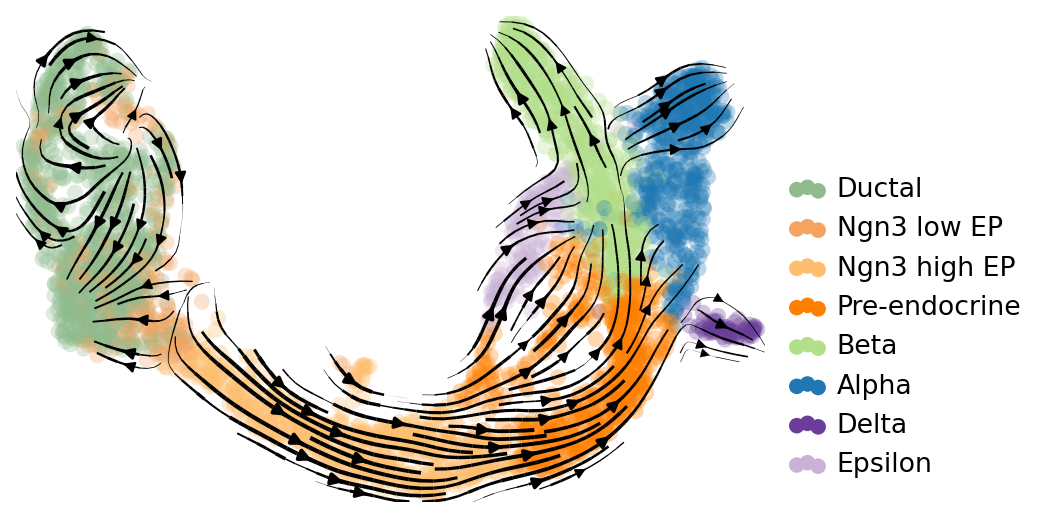

In [22]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.velocity_embedding_stream(adata_target, 
                                     basis='umap',
                                     title = "",
                                     legend_loc = "lower right",
                                     ax = ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'pancreatic_endocrine'/ 'intro_vector_field.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

In [23]:
# save model
if SAVE_DATASETS:
    model = DATA_DIR / 'pancreatic_endocrine' / 'rgv_model'
    reg_vae.save(model)

## Regulation is important for terminal states identification

### Delete regulation

In [24]:
### Test the influence of delate all regulations
GRN = reg_vae.module.v_encoder.fc1.weight.detach().clone()

In [25]:
reg_vae.module.v_encoder.fc1.weight.data = GRN * 0

In [26]:
adata_target_no_regulation = add_regvelo_outputs_to_adata(reg_bdata, reg_vae)

In [27]:
scv.tl.velocity_graph(adata_target_no_regulation)

computing velocity graph (using 1/128 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


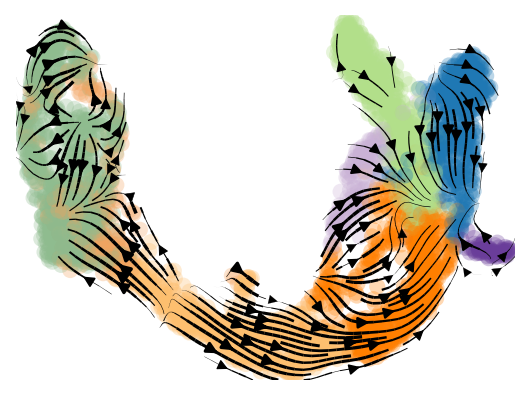

In [28]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 3))
    scv.pl.velocity_embedding_stream(adata_target_no_regulation, 
                                     basis='umap',
                                     title = "",
                                     legend_loc = False,
                                     ax = ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'pancreatic_endocrine'/ 'no_regulation_vector_field.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

In [29]:
n_states = 8
vk = cr.kernels.VelocityKernel(adata_target_no_regulation)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_target_no_regulation).compute_transition_matrix()
g_rgv = cr.estimators.GPCCA(vk)
## evaluate the fate prob on original space
g_rgv.compute_macrostates(n_states=n_states,cluster_key="clusters")

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

GPCCA[kernel=VelocityKernel[n=3696], initial_states=None, terminal_states=None]

In [30]:
terminal_states = [
        "Beta",
        "Alpha",
        "Delta",
        "Epsilon"
    ]
g_rgv.set_terminal_states(list(set(g_rgv.macrostates.cat.categories.tolist()).intersection(terminal_states)))

GPCCA[kernel=VelocityKernel[n=3696], initial_states=None, terminal_states=['Alpha']]

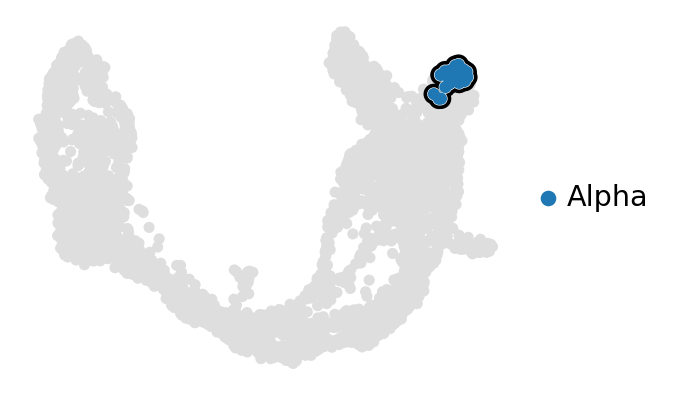

In [31]:
if SAVE_FIGURES:
    plot_states(
        adata_target_no_regulation,
        estimator=g_rgv,
        figsize = (4,3),
        which="terminal_states",
        basis="umap",
        legend_loc="right",
        title="",
        size=100,
        dpi = 400,
        format = "svg",
        fpath = FIG_DIR / "pancreatic_endocrine" / "terminal_state_no_regulation.svg",
    )

In [32]:
reg_vae.module.v_encoder.fc1.weight.data = GRN

### randomize the regulation network

In [33]:
gene = adata_target.var.index.tolist()
random.shuffle(gene)
GRN = pd.DataFrame(GRN.cpu().numpy(),index = gene, columns = gene)
GRN = GRN.loc[adata_target.var.index.tolist(),adata_target.var.index.tolist()]
GRN = torch.tensor(np.array(GRN))
GRN = GRN.to("cuda:0")
reg_vae.module.v_encoder.fc1.weight.data = GRN
adata_target_random_regulation = add_regvelo_outputs_to_adata(reg_bdata, reg_vae)

In [34]:
scv.tl.velocity_graph(adata_target_random_regulation)

computing velocity graph (using 1/128 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


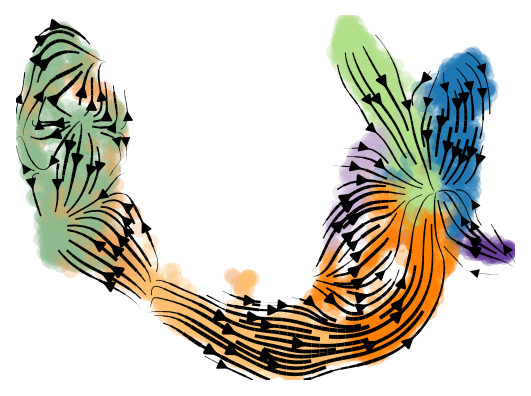

In [35]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 3))
    scv.pl.velocity_embedding_stream(adata_target_random_regulation, 
                                     basis='umap',
                                     title = "",
                                     legend_loc = False,
                                     ax = ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'pancreatic_endocrine'/ 'randomize_regulation_vector_field.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

In [36]:
n_states = 8
vk = cr.kernels.VelocityKernel(adata_target_random_regulation)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_target_random_regulation).compute_transition_matrix()
g_rgv = cr.estimators.GPCCA(vk)
## evaluate the fate prob on original space
g_rgv.compute_macrostates(n_states=n_states,cluster_key="clusters")

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

GPCCA[kernel=VelocityKernel[n=3696], initial_states=None, terminal_states=None]

In [37]:
terminal_states = [
        "Beta",
        "Alpha",
        "Delta",
        "Epsilon"
    ]
g_rgv.set_terminal_states(list(set(g_rgv.macrostates.cat.categories.tolist()).intersection(terminal_states)))

GPCCA[kernel=VelocityKernel[n=3696], initial_states=None, terminal_states=['Alpha']]

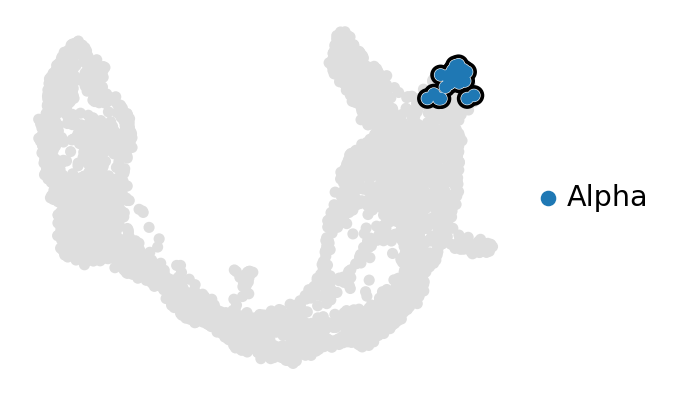

In [38]:
if SAVE_FIGURES:
    plot_states(
        adata_target_random_regulation,
        estimator=g_rgv,
        figsize = (4,3),
        which="terminal_states",
        basis="umap",
        legend_loc="right",
        title="",
        size=100,
        dpi = 400,
        format = "svg",
        fpath = FIG_DIR / "pancreatic_endocrine" / "terminal_state_randomize_regulation.svg",
    )

## Benchmark RegVelo terminal states identification

In [39]:
reg_vae = REGVELOVI.load(model,reg_bdata)
adata_target = add_regvelo_outputs_to_adata(reg_bdata, reg_vae)
scv.tl.velocity_graph(adata_target)

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/rgv_model/
         model.pt already downloaded                                                                               
computing velocity graph (using 1/128 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: 

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [40]:
my_list = adata_target.obs["clusters"].tolist()
summary = dict(Counter(my_list))
print(summary)

{'Pre-endocrine': 592, 'Ductal': 916, 'Alpha': 481, 'Ngn3 high EP': 642, 'Delta': 70, 'Beta': 591, 'Ngn3 low EP': 262, 'Epsilon': 142}


In [41]:
terminal_states = [
        "Beta",
        "Alpha",
        "Delta",
        "Epsilon"
    ]

all_states = list(set(adata_target.obs["clusters"].tolist()))

all_id = all_states.copy()
all_type = all_states.copy()
for i in all_states:
    for j in [1,2,3,4,5,6,7,8,9,10,11,12]:
        all_id.append(i+"_"+str(j))
        all_type.append(i)
all_dict = dict(zip(all_id, all_type))

In [42]:
n_states = 8
vk = cr.kernels.VelocityKernel(adata_target)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_target).compute_transition_matrix()
g = cr.estimators.GPCCA(vk)
## evaluate the fate prob on original space
g.compute_macrostates(n_states=n_states,cluster_key="clusters")

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: 

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

GPCCA[kernel=VelocityKernel[n=3696], initial_states=None, terminal_states=None]

In [43]:
g.set_terminal_states(["Alpha", "Delta", "Beta", "Epsilon"])

GPCCA[kernel=VelocityKernel[n=3696], initial_states=None, terminal_states=['Alpha', 'Beta', 'Delta', 'Epsilon']]

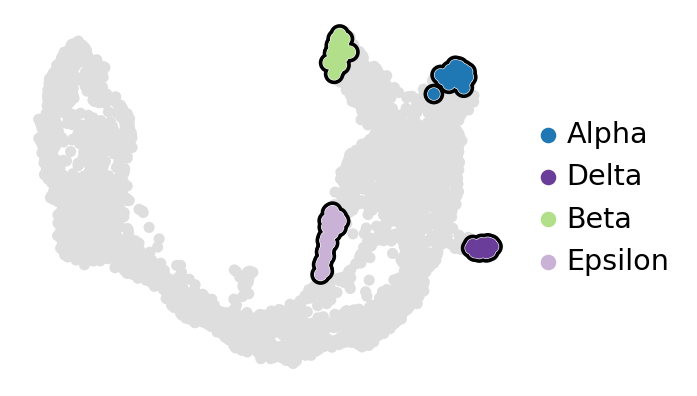

In [44]:
if SAVE_FIGURES:
    plot_states(
            adata_target,
            estimator=g,
            figsize = (4,3),
            which="terminal_states",
            basis="umap",
            legend_loc="right",
            title="",
            size=100,
            dpi = 400,
            format = "svg",
            fpath = FIG_DIR / "pancreatic_endocrine" / "terminal_state_full_regulation.svg",
    )

In [45]:
pre_value_rgv = stair_vec(g,0.8,terminal_states,"clusters",all_dict)

[1]
[1, 1]
[1, 1, 2]
[1, 1, 2, 3]
[1, 1, 2, 3, 3]
[1, 1, 2, 3, 3, 3]
[1, 1, 2, 3, 3, 3, 4]
[1, 1, 2, 3, 3, 3, 4, 4]
[1, 1, 2, 3, 3, 3, 4, 4, 4]
Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 1, 2, 3, 3, 3, 4, 4, 4, 4]
[1, 1, 2, 3, 3, 3, 4, 4, 4, 4, 4]


In [46]:
## calculate tsi_score
points = np.linspace(0, 1, 21)[:20]
tsi = TSI_score(points,"clusters",terminal_states,g,all_dict)

[1]
[1, 1]
[1, 1, 2]
[1, 1, 2, 3]
[1, 1, 2, 3, 3]
[1, 1, 2, 3, 3, 3]
[1, 1, 2, 3, 3, 3, 4]
[1, 1, 2, 3, 3, 3, 4, 4]
[1, 1, 2, 3, 3, 3, 4, 4, 4]
Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 1, 2, 3, 3, 3, 4, 4, 4, 4]
[1, 1, 2, 3, 3, 3, 4, 4, 4, 4, 4]
[1]
[1, 1]
[1, 1, 2]
[1, 1, 2, 3]
[1, 1, 2, 3, 3]
[1, 1, 2, 3, 3, 3]
[1, 1, 2, 3, 3, 3, 4]
[1, 1, 2, 3, 3, 3, 4, 4]
[1, 1, 2, 3, 3, 3, 4, 4, 4]
Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 1, 2, 3, 3, 3, 4, 4, 4, 4]
[1, 1, 2, 3, 3, 3, 4, 4, 4, 4, 4]
[1]
[1, 1]
[1, 1, 2]
[1, 1, 2, 3]
[1, 1, 2, 3, 3]
[1, 1, 2, 3, 3, 3]
[1, 1, 2, 3, 3, 3, 4]
[1, 1, 2, 3, 3, 3, 4, 4]
[1, 1, 2, 3, 3, 3, 4, 4, 4]
Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.


### Run veloVI

In [47]:
VELOVI.setup_anndata(adata_target, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata_target)
vae.train()

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100 80GB P

Epoch 423/500:  85%|████████▍ | 423/500 [01:16<00:13,  5.51it/s, loss=-2.87e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2741.510. Signaling Trainer to stop.


In [48]:
adata_velovi = adata_target.copy()
add_outputs_to_adata(adata_velovi, vae)

In [49]:
points = np.linspace(0, 1, 21)[:20]
vk = cr.kernels.VelocityKernel(adata_velovi)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_velovi).compute_transition_matrix()
g = cr.estimators.GPCCA(vk)
tsi_velovi = TSI_score(points,"clusters",terminal_states,g,all_dict)

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

[1]
[1, 1]
[1, 1, 1]
Error: Discretizing leads to a cluster with `1` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 1, 1, 1]
[1, 1, 1, 1, 2]
[1, 1, 1, 1, 2, 2]
[1, 1, 1, 1, 2, 2, 3]
[1, 1, 1, 1, 2, 2, 3, 3]
[1, 1, 1, 1, 2, 2, 3, 3, 4]
[1, 1, 1, 1, 2, 2, 3, 3, 4, 4]
[1, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4]
[1]
[1, 1]
[1, 1, 1]
Error: Discretizing leads to a cluster with `1` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 1, 1, 1]
[1, 1, 1, 1, 2]
[1, 1, 1, 1, 2, 2]
[1, 1, 1, 1, 2, 2, 3]
[1, 1, 1, 1, 2, 2, 3, 3]
[1, 1, 1, 1, 2, 2, 3, 3, 4]
[1, 1, 1, 1, 2, 2, 3, 3, 4, 4]
[1, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4]
[1]
[1, 1]
[1, 1, 1]
Error: Discretizing leads to a cluster with `1` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 1, 1, 1]
[1, 1, 1, 1, 2]
[1, 1, 1, 1, 2, 2]
[1, 1, 1, 1, 2, 2, 3]
[1, 1, 1, 1, 2, 2, 3, 3]
[1, 1, 1, 1, 2, 2, 3, 3, 4]


In [50]:
pre_value_velovi = stair_vec(g,0.8,terminal_states,"clusters",all_dict)

[1]
[1, 1]
[1, 1, 1]
Error: Discretizing leads to a cluster with `1` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 1, 1, 1]
[1, 1, 1, 1, 2]
[1, 1, 1, 1, 2, 2]
[1, 1, 1, 1, 2, 2, 3]
[1, 1, 1, 1, 2, 2, 3, 3]
[1, 1, 1, 1, 2, 2, 3, 3, 4]
[1, 1, 1, 1, 2, 2, 3, 3, 4, 4]
[1, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4]


### Run scVelo

In [51]:
## Compute scVelo
adata_raw = adata_target.copy()
scv.tl.recover_dynamics(
        adata_raw, var_names=adata_raw.var_names, n_jobs=8, fit_scaling=False
    )
scv.tl.velocity(adata_raw, mode="dynamical")

recovering dynamics (using 8/128 cores)


  0%|          | 0/1000 [00:00<?, ?gene/s]

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:02:33) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [52]:
points = np.linspace(0, 1, 21)[:20]
vk = cr.kernels.VelocityKernel(adata_raw)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_raw).compute_transition_matrix()
g = cr.estimators.GPCCA(vk)
tsi_scv = TSI_score(points,"clusters",terminal_states,g,all_dict)

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 2]
[1, 1, 1, 1, 2, 2]
[1, 1, 1, 1, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 2]
[1, 1, 1, 1, 2, 2]
[1, 1, 1, 1, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 2]
[1, 1, 1, 1, 2, 2]
[1, 1, 1, 1, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 2]
[1, 1, 1, 1, 2, 2]
[1, 1, 1, 1, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 2]
[1, 1, 1, 1, 2, 2]
[1, 1, 1, 1, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2

In [53]:
pre_value_scv = stair_vec(g,0.8,terminal_states,"clusters",all_dict)

[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 2]
[1, 1, 1, 1, 2, 2]
[1, 1, 1, 1, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]


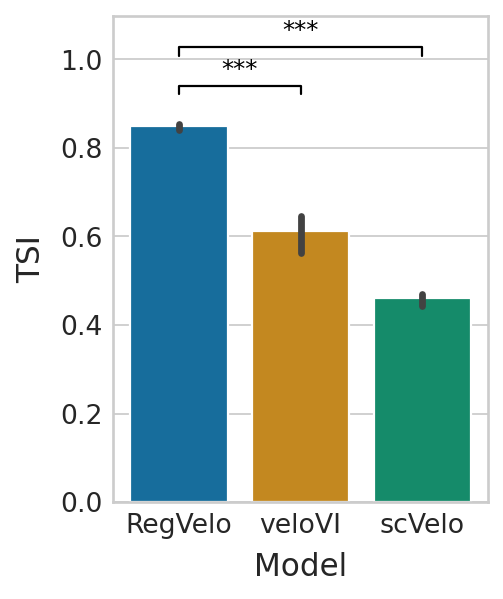

In [54]:
df = pd.DataFrame(
    {
        "TSI":  tsi + tsi_velovi + tsi_scv,
        "Model": ["RegVelo"] * 20 + ["veloVI"] * 20 + ["scVelo"] * 20
    }
)        
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 4))

    sns.barplot(data=df, x="Model", y="TSI", palette="colorblind", ax=ax)
    
    ttest_res = wilcoxon(tsi, tsi_velovi, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=1, significance=significance, lw=1, bracket_level=1.05, c="k", level=0,
    )

    ttest_res = wilcoxon(tsi, tsi_scv, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=2, significance=significance, lw=1, c="k", level=2, bracket_level=0.9
    )

    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])
    
    #ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    #ax.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1.0]);
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "pancreatic_endocrine" / "TSI_benchmark_update.svg",
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )
    plt.show()

## Using the example veloVI and scVelo preprocessing procedure to do fate prediction

In [55]:
adata_raw = sc.read_h5ad("RegVelo_datasets/pancreatic endocrine/endocrinogenesis_day15.h5ad")
scv.pp.filter_and_normalize(adata_raw, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata_raw, n_pcs=30, n_neighbors=30)

Filtered out 21611 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [56]:
adata_raw_vi = preprocess_data(adata_raw)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [57]:
VELOVI.setup_anndata(adata_raw_vi, spliced_layer="Ms", unspliced_layer="Mu")
vae_example = VELOVI(adata_raw_vi)
vae_example.train()

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100 80GB P

Epoch 500/500: 100%|██████████| 500/500 [01:30<00:00,  5.75it/s, loss=-2.41e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [01:30<00:00,  5.55it/s, loss=-2.41e+03, v_num=1]


In [58]:
add_outputs_to_adata(adata_raw_vi, vae_example)

In [59]:
points = np.linspace(0, 1, 21)[:20]
vk = cr.kernels.VelocityKernel(adata_raw_vi)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_raw_vi).compute_transition_matrix()
g = cr.estimators.GPCCA(vk)
tsi_velovi_raw = TSI_score(points,"clusters",terminal_states,g,all_dict)

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 2]
[1, 1, 1, 2, 3]
[1, 1, 1, 2, 3, 3]
[1, 1, 1, 2, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3]
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 2]
[1, 1, 1, 2, 3]
[1, 1, 1, 2, 3, 3]
[1, 1, 1, 2, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3]
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 2]
[1, 1, 1, 2, 3]
[1, 1, 1, 2, 3, 3]
[1, 1, 1, 2, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3]
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 2]
[1, 1, 1, 2, 3]
[1, 1, 1, 2, 3, 3]
[1, 1, 1, 2, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3]
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 2]
[1, 1, 1, 2, 3]
[1, 1, 1, 2, 3, 3]
[1, 1, 1, 2, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3

In [60]:
pre_value_velovi_raw = stair_vec(g,0.8,terminal_states,"clusters",all_dict)

[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 2]
[1, 1, 1, 2, 3]
[1, 1, 1, 2, 3, 3]
[1, 1, 1, 2, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3, 3]
[1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3]


In [61]:
scv.tl.recover_dynamics(
        adata_raw, n_jobs=8
    )
scv.tl.velocity(adata_raw, mode="dynamical")

recovering dynamics (using 8/128 cores)


  0%|          | 0/1043 [00:00<?, ?gene/s]

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:01:47) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [62]:
points = np.linspace(0, 1, 21)[:20]
vk = cr.kernels.VelocityKernel(adata_raw)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_raw).compute_transition_matrix()
g = cr.estimators.GPCCA(vk)
tsi_scv_raw = TSI_score(points,"clusters",terminal_states,g,all_dict)

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

[1]
[1, 1]
[1, 1, 2]
[1, 1, 2, 2]
Error: Discretizing leads to a cluster with `0` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 1, 2, 2, 2]
[1, 1, 2, 2, 2, 2]
[1, 1, 2, 2, 2, 2, 3]
[1, 1, 2, 2, 2, 2, 3, 3]
[1, 1, 2, 2, 2, 2, 3, 3, 3]
[1, 1, 2, 2, 2, 2, 3, 3, 3, 3]
[1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3]
[1]
[1, 1]
[1, 1, 2]
[1, 1, 2, 2]
Error: Discretizing leads to a cluster with `0` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 1, 2, 2, 2]
[1, 1, 2, 2, 2, 2]
[1, 1, 2, 2, 2, 2, 3]
[1, 1, 2, 2, 2, 2, 3, 3]
[1, 1, 2, 2, 2, 2, 3, 3, 3]
[1, 1, 2, 2, 2, 2, 3, 3, 3, 3]
[1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3]
[1]
[1, 1]
[1, 1, 2]
[1, 1, 2, 2]
Error: Discretizing leads to a cluster with `0` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 1, 2, 2, 2]
[1, 1, 2, 2, 2, 2]
[1, 1, 2, 2, 2, 2, 3]
[1, 1, 2, 2, 2, 2, 3, 3]
[1, 1, 2, 2, 2, 2, 3, 3, 3]


In [63]:
pre_value_scv_raw = stair_vec(g,0.8,terminal_states,"clusters",all_dict)

[1]
[1, 1]
[1, 1, 2]
[1, 1, 2, 2]
Error: Discretizing leads to a cluster with `0` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 1, 2, 2, 2]
[1, 1, 2, 2, 2, 2]
[1, 1, 2, 2, 2, 2, 3]
[1, 1, 2, 2, 2, 2, 3, 3]
[1, 1, 2, 2, 2, 2, 3, 3, 3]
[1, 1, 2, 2, 2, 2, 3, 3, 3, 3]
[1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3]


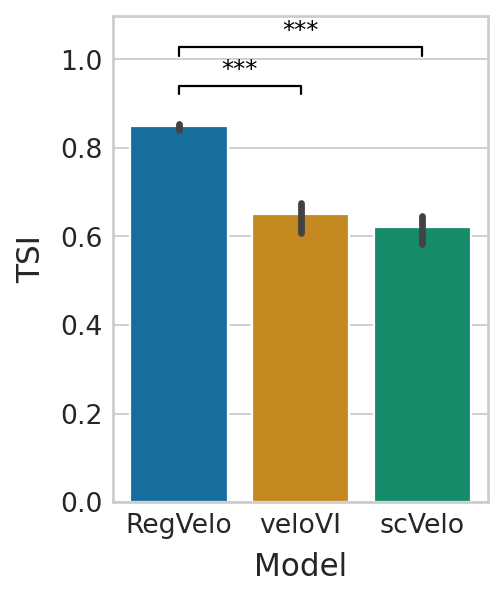

In [64]:
df = pd.DataFrame(
    {
        "TSI":  tsi + tsi_velovi_raw + tsi_scv_raw,
        "Model": ["RegVelo"] * 20 + ["veloVI"] * 20 + ["scVelo"] * 20
    }
)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 4))

    sns.barplot(data=df, x="Model", y="TSI", palette="colorblind", ax=ax)
    
    ttest_res = wilcoxon(tsi, tsi_velovi, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=1, significance=significance, lw=1, bracket_level=1.05, c="k", level=0,
    )

    ttest_res = wilcoxon(tsi, tsi_scv, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=2, significance=significance, lw=1, c="k", level=2, bracket_level=0.9
    )

    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])
    
    #ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    #ax.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1.0]);
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "pancreatic_endocrine"/ "TSI_benchmark_update_all.svg",
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )
    plt.show()

In [65]:
### plot the recovery figure
df = pd.DataFrame({"number_macrostate":range(0,12),
                   "RegVelo":[0]+pre_value_rgv,
                   "veloVI":[0]+pre_value_velovi_raw,
                   "scVelo":[0]+pre_value_scv_raw})

In [66]:
df = pd.melt(df, ['number_macrostate'])

In [67]:
colors = sns.color_palette("colorblind", n_colors=3)
colors = colors + [(0.8274509803921568, 0.8274509803921568, 0.8274509803921568)]

/tmp/ipykernel_2955673/1635709572.py:8: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.lineplot(x='number_macrostate', y='value', hue='variable', style='variable', palette=colors, drawstyle='steps-post', data=df, linewidth=3)


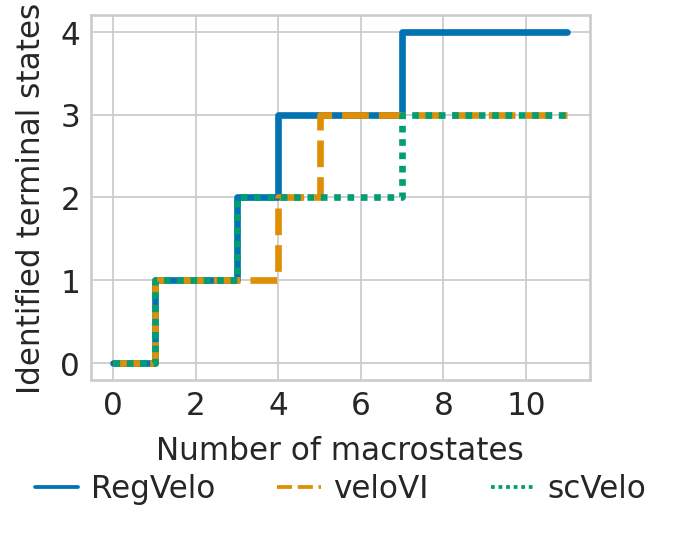

In [68]:
# Set figure size
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    
    rcParams['figure.figsize'] = 4, 3

    # Plot the grid plot
    ax = sns.lineplot(x='number_macrostate', y='value', hue='variable', style='variable', palette=colors, drawstyle='steps-post', data=df, linewidth=3)

    # Set labels and titles
    ax.set(ylabel='Number of correct predictions')
    plt.xlabel('Number of macrostates', fontsize=14)
    plt.ylabel('Identified terminal states', fontsize=14)

    # Customize tick parameters for better readability
    ax.set_xticks([0, 2,4,6,8,10])
    ax.set_xticklabels([0, 2,4,6,8,10]);
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), shadow=True, ncol=4,fontsize = 14)

    if SAVE_FIGURES:
        plt.savefig(
                FIG_DIR / "pancreatic_endocrine" / "state_identification.svg",
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )
    plt.show()

In [69]:
### compare expresson fit
### derive fit result of RegVelo
fit_s_rgv, fit_u_rgv = rgv_expression_fit(reg_vae,n_samples=20)

In [70]:
### derive fit result of velovi
fit_s_velovi, fit_u_velovi = vae.get_expression_fit(n_samples=20)

In [71]:
### derive fit result of scvelo
adata_target_scv = adata_target.copy()
scv.tl.recover_dynamics(
        adata_target_scv, fit_scaling=False, var_names=adata_target_scv.var_names, n_jobs=8
    )
scv.tl.velocity(adata_target_scv, mode="dynamical")

recovering dynamics (using 8/128 cores)


  0%|          | 0/1000 [00:00<?, ?gene/s]

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:01:18) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [72]:
fit_result_scv = get_fit_scvelo(adata_target_scv)

1000it [00:03, 319.11it/s]


In [73]:
def compute_mse(ms, mu, fit_s, fit_u):
    mse_s = np.mean((fit_s - ms) ** 2, axis=0)
    mse_u = np.mean((fit_u - mu) ** 2, axis=0)
    #scvelo_mse_s = np.mean((scvelo_fit_s - ms) ** 2, axis=0)
    #scvelo_mse_u = np.mean((scvelo_fit_u - mu) ** 2, axis=0)

    mse_df = pd.DataFrame()

    mse_df["MSE"] = np.concatenate([mse_s, mse_u]).ravel()
    mse_df["Feature"] = ["Spliced"] * len(mse_s) + ["Unspliced"] * len(mse_u)
    return mse_df
    
ms = adata_target.to_df("Ms")
mu = adata_target.to_df("Mu")
mse_df = compute_mse(
    ms,
    mu,
    fit_s_rgv,
    fit_u_rgv,
)
mse_df["Method"] = "RegVelo"

mse_df2 = compute_mse(
    ms,
    mu,
    fit_s_velovi,
    fit_u_velovi,
)
mse_df2["Method"] = "veloVI"

mse_df3 = compute_mse(
    ms,
    mu,
    fit_result_scv[0],
    fit_result_scv[1],
)

mse_df3["Method"] = "scVelo"
mse_df_all = pd.concat([mse_df,mse_df2,mse_df3], axis=0)

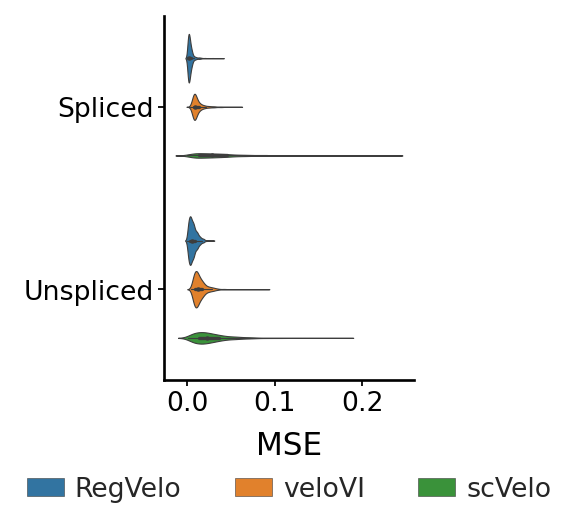

In [74]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(2, 3))
    sns.set_style(style="whitegrid")
    sns.violinplot(
            data=mse_df_all,
            orient="h",
            ax=ax,
            y="Feature",
            x="MSE",
            hue="Method",
            width=0.8,
            linewidth=0.5
        )
    
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=3,frameon=False)
    ax.set_ylabel('')
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "pancreatic_endocrine" / "mse_result.svg",
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )
    
    plt.show()

## Epsilon cell will differentiate to alpha cell

In [75]:
reg_vae = REGVELOVI.load(model,reg_bdata)

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/rgv_model/
         model.pt already downloaded                                                                               


In [76]:
## Compare the fate probability corrrelation
terminal_states = [
        "Beta",
        "Alpha",
        "Delta",
        "Epsilon"
    ]

n_states = 8
vk = cr.kernels.VelocityKernel(adata_target)
vk.compute_transition_matrix()

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

VelocityKernel[n=3696, model='deterministic', similarity='correlation', softmax_scale=14.27]

In [77]:
ck = cr.kernels.ConnectivityKernel(adata_target).compute_transition_matrix()

In [78]:
g = cr.estimators.GPCCA(vk)

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


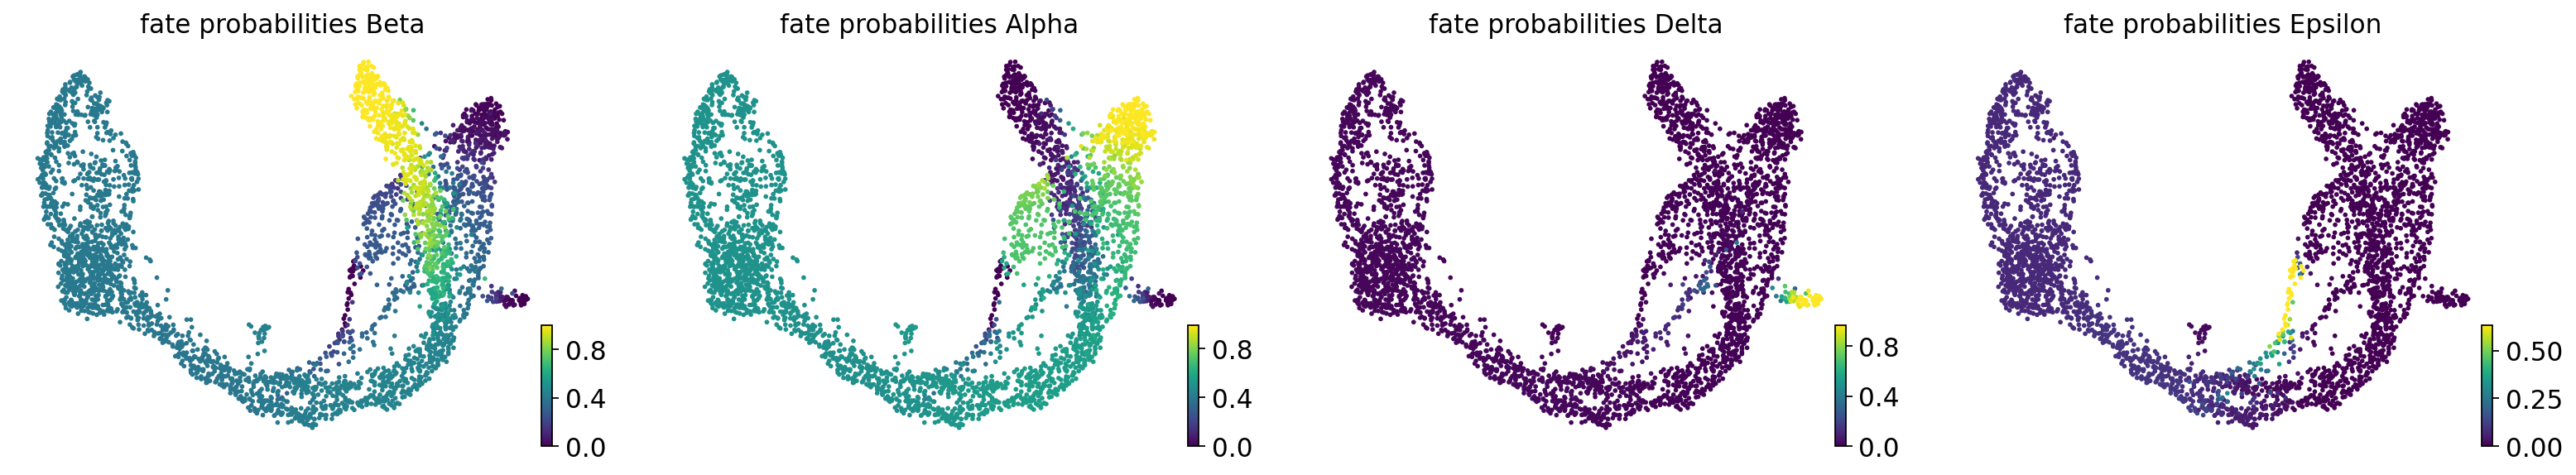

In [80]:
## evaluate the fate prob on original space
g.compute_macrostates(n_states=n_states,cluster_key="clusters")
g.set_terminal_states(terminal_states)
g.compute_fate_probabilities(solver = "direct")
g.plot_fate_probabilities(same_plot=False)
fate_prob_rgv = g.fate_probabilities
sampleID = adata_target.obs.index.tolist()
fate_name = fate_prob_rgv.names.tolist()
fate_prob_rgv = pd.DataFrame(fate_prob_rgv,index= sampleID,columns=fate_name)

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


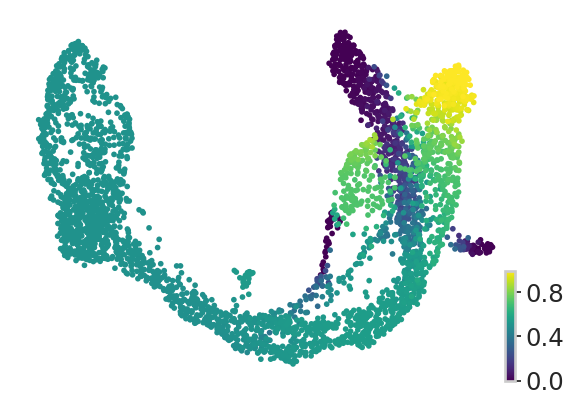

In [81]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4,3))
    sns.set_style(style="whitegrid")
    g.plot_fate_probabilities(states = ["Alpha"],same_plot=False,title = "",ax = ax)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "pancreatic_endocrine" / "alpha_cell_rgv.svg",
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )
    
    plt.show()

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3 [00:00<?, ?/s]

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


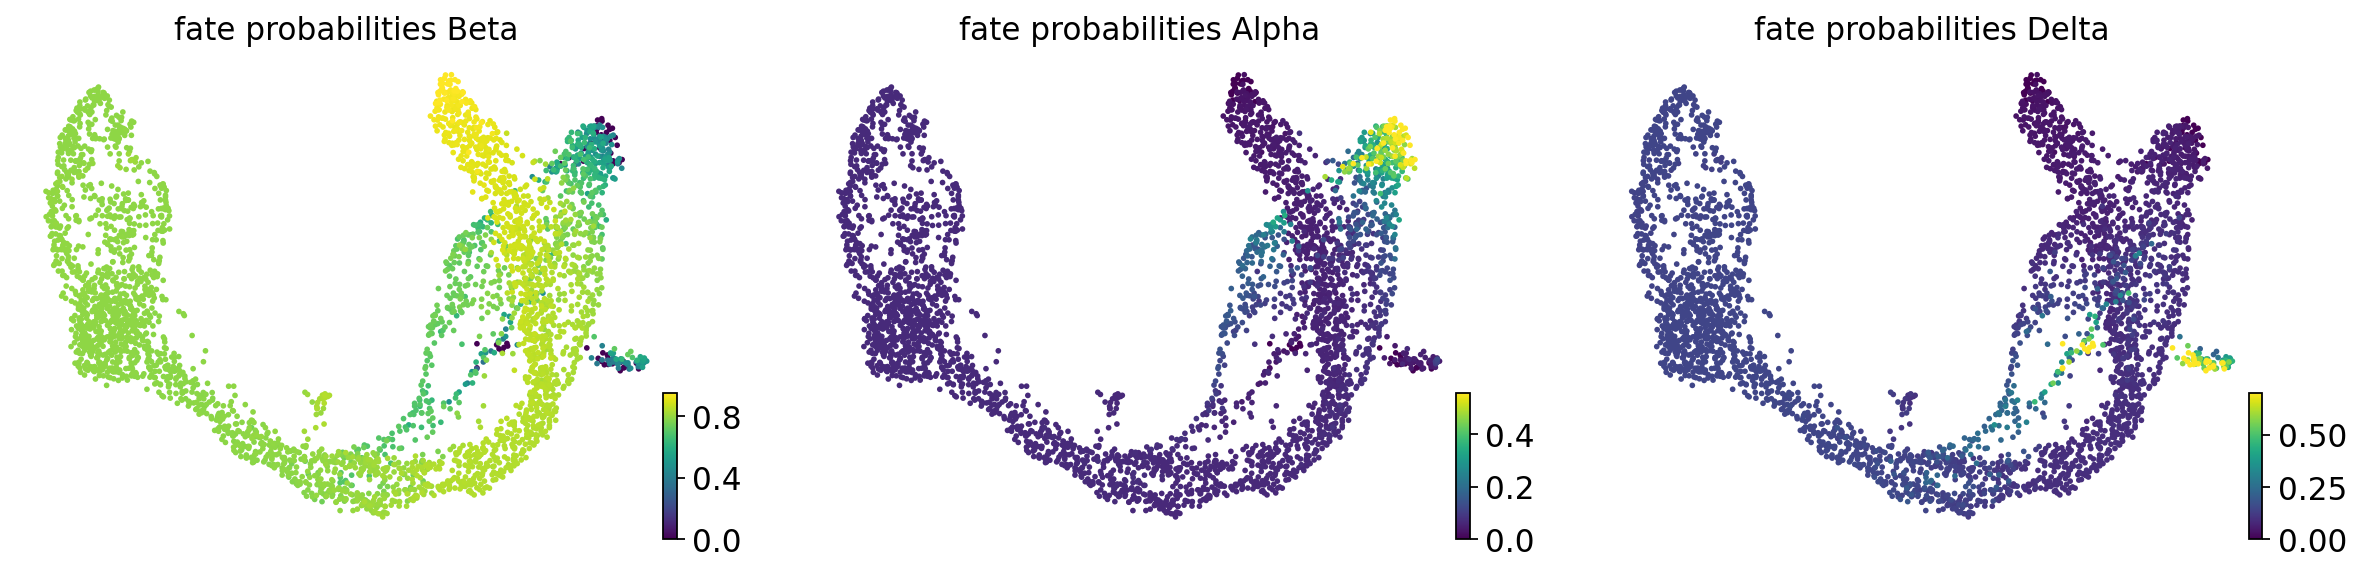

In [82]:
terminal_states = [
        "Beta",
        "Alpha",
        "Delta",
    ]

n_states = 11
vk = cr.kernels.VelocityKernel(adata_raw)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_raw).compute_transition_matrix()
g = cr.estimators.GPCCA(vk)
## evaluate the fate prob on original space
g.compute_macrostates(n_states=n_states,cluster_key="clusters")
g.set_terminal_states(terminal_states)
g.compute_fate_probabilities()
g.plot_fate_probabilities(same_plot=False)
fate_prob_raw = g.fate_probabilities
sampleID = adata_raw.obs.index.tolist()
fate_name = fate_prob_raw.names.tolist()
fate_prob_raw = pd.DataFrame(fate_prob_raw,index= sampleID,columns=fate_name)

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


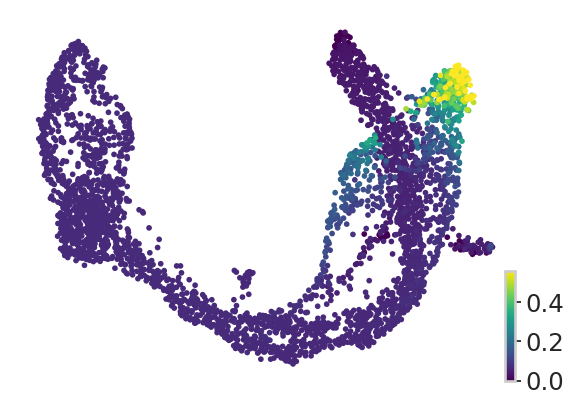

In [83]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4,3))
    sns.set_style(style="whitegrid")
    g.plot_fate_probabilities(states = ["Alpha"],same_plot=False,title = "",ax = ax)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "pancreatic_endocrine" / "alpha_cell_scv.svg",
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )
    
    plt.show()

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3 [00:00<?, ?/s]

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


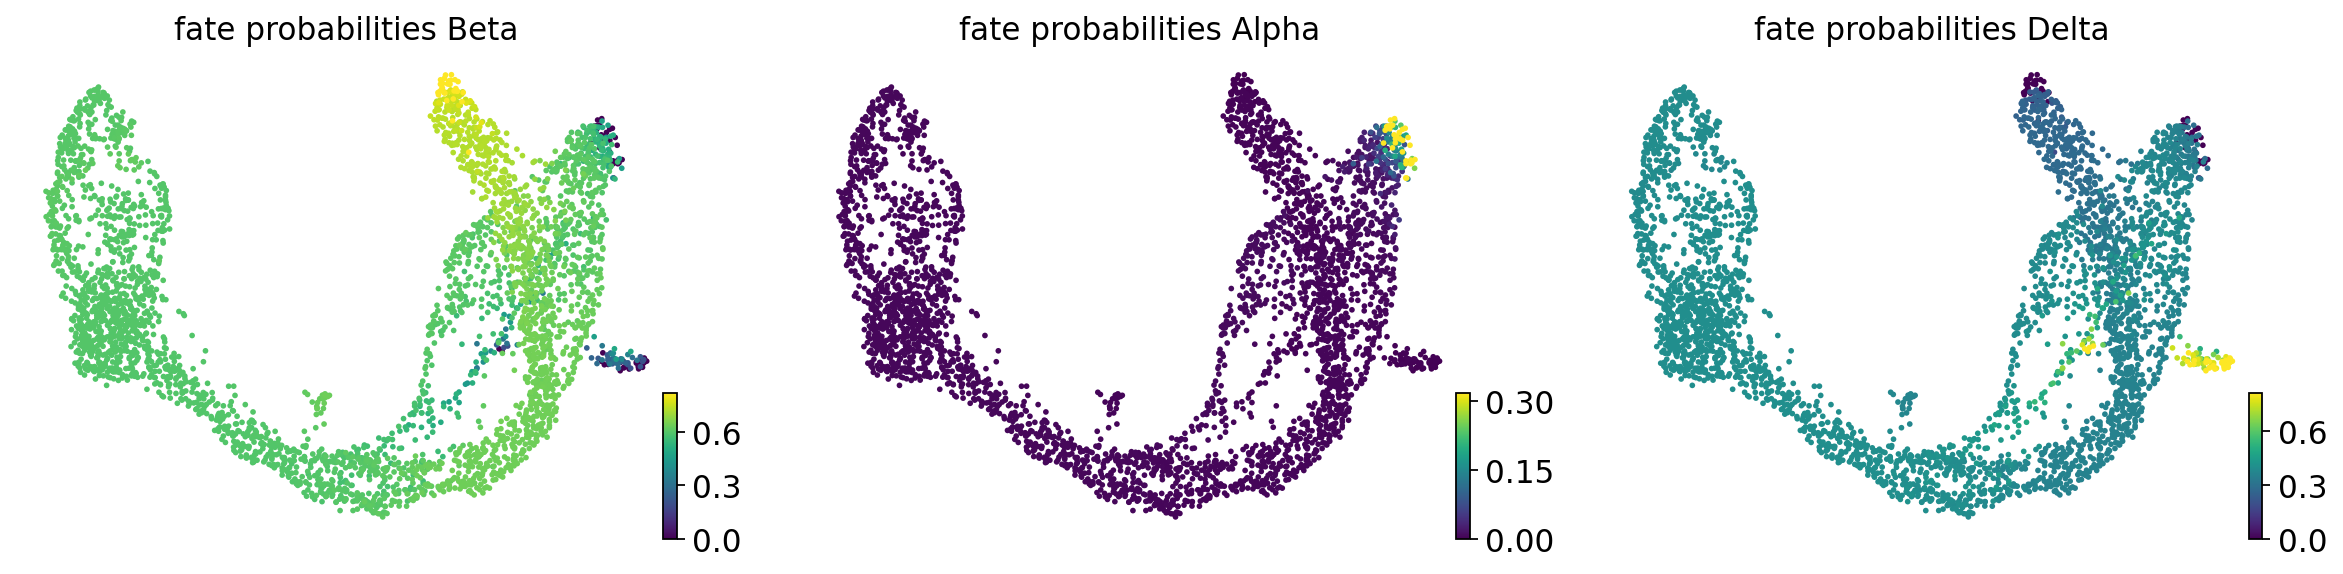

In [84]:
terminal_states = [
        "Beta",
        "Alpha",
        "Delta"
    ]

n_states = 11
vk = cr.kernels.VelocityKernel(adata_raw_vi)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_raw_vi).compute_transition_matrix()
g = cr.estimators.GPCCA(vk)
## evaluate the fate prob on original space
g.compute_macrostates(n_states=n_states,cluster_key="clusters")
g.set_terminal_states(terminal_states)
g.compute_fate_probabilities()
g.plot_fate_probabilities(same_plot=False)
fate_prob_velovi = g.fate_probabilities
sampleID = adata_velovi.obs.index.tolist()
fate_name = fate_prob_velovi.names.tolist()
fate_prob_velovi = pd.DataFrame(fate_prob_velovi,index= sampleID,columns=fate_name)

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


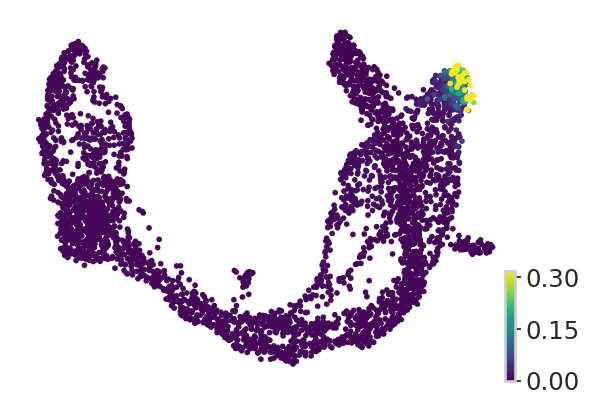

In [85]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4,3))
    sns.set_style(style="whitegrid")
    g.plot_fate_probabilities(states = ["Alpha"],same_plot=False,title = "",ax = ax)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "pancreatic_endocrine" / "alpha_cell_vi.svg",
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )
    
    plt.show()

In [86]:
adata_target.obs["Alpha"] = fate_prob_rgv.loc[:,"Alpha"]
adata_target.obs["Epsilon"] = fate_prob_rgv.loc[:,"Epsilon"]

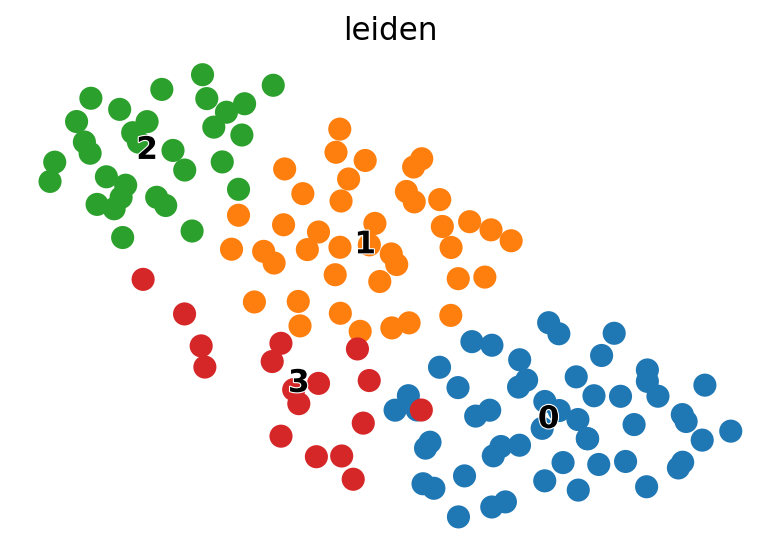

In [87]:
## identify two Epsilon population
Epsilon = adata_target[adata_target.obs["clusters"] == "Epsilon"].copy()
## calculate pca and plot umap
sc.tl.pca(Epsilon)
sc.pp.neighbors(Epsilon)
sc.tl.leiden(Epsilon)
sc.tl.umap(Epsilon)
scv.pl.umap(Epsilon, color='leiden',legend_loc = "on data")

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


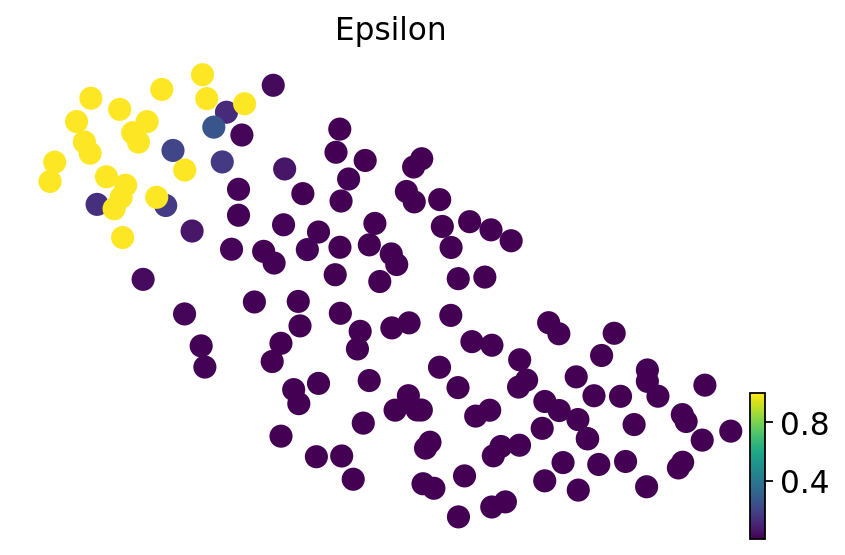

In [88]:
scv.pl.umap(Epsilon, color='Epsilon')

In [89]:
TF_list = list(set(TF.iloc[:,0].tolist()).intersection(adata_target.var_names))

In [90]:
## screening TF, identify the driver
pval = []
for i in TF_list:
    x = Epsilon[Epsilon.obs["leiden"]!="2",i].X.A.reshape(-1)
    y = Epsilon[Epsilon.obs["leiden"]=="2",i].X.A.reshape(-1)
    _,res = ranksums(x,y,alternative = "greater")
    pval.append(res)

In [91]:
res = pd.DataFrame({"TF":list(TF_list),"Pval":pval})
res = res.sort_values(by='Pval')
res

TF      Pval
75   Tagln2  0.000003
19  Smarca1  0.000539
60   Zbtb20  0.001801
32     Irx1  0.002594
2    Pou6f2  0.003692
..      ...       ...
23     Rfx6  0.999987
76     Fhl2  0.999997
83     Hes6  1.000000
5      Arg1  1.000000
1   Neurog3  1.000000

[87 rows x 2 columns]

In [92]:
cell_states = np.array(Epsilon.obs["leiden"].copy())
cell_states[cell_states == "2"] = "State1"
cell_states[cell_states != "State1"] = "State2"

In [93]:
Epsilon.obs["cell_states"] = list(cell_states)

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


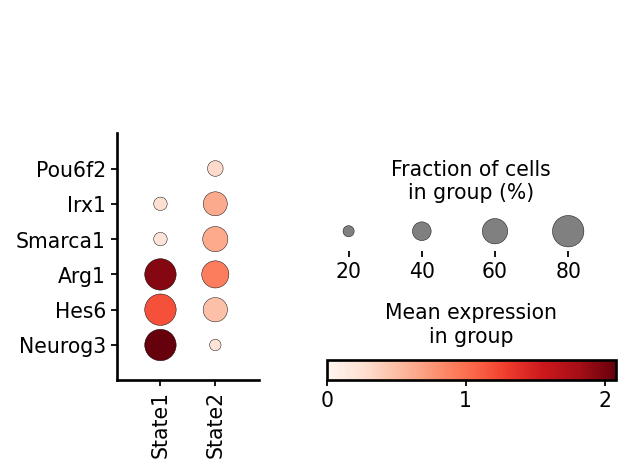

In [94]:
## Visualize gene expression dynamics
with mplscience.style_context():
    markers = ["Pou6f2","Irx1","Smarca1","Arg1","Hes6","Neurog3"]
    fig, ax = plt.subplots(figsize=(4,3))
    #sns.set_style(style="whitegrid")
    sc.pl.dotplot(Epsilon, markers, groupby='cell_states',swap_axes=True,dot_max = 0.8,ax = ax)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "pancreatic_endocrine" / "feature_marker_expression.svg",
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )
    
    plt.show()